In [51]:
from arango import ArangoClient
import os
import nltk
from nltk.tokenize import sent_tokenize
import json
import numpy as np
nltk.download('punkt')
from tqdm import tqdm

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Stark\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
client = ArangoClient(hosts='http://localhost:8529')
db = client.db('Database_Material_Science', username='root', password='praddy')


## Load up the collections

In [4]:
entities = db.collection('entities')
publications = db.collection('publications')
edges = db.collection('publications_entities_edges')

In [5]:
from matplotlib import pyplot as plt
import pandas as pd

# 1. Basic analysis:

In [6]:
# Analysis year wise to see where we see a stark drop:

year_cap = 2024
QUERY_pub_by_year = f"""
                        LET yearCap = {year_cap}
                        FOR publication IN publications
                            FILTER publication.year <= yearCap
                            SORT publication.year ASC
                            RETURN {{ _key: publication._key, doi: publication.doi, year: publication.year }}
                        """

cursor = db.aql.execute(QUERY_pub_by_year)
results = list(cursor)

In [7]:
matkg_df = pd.DataFrame(results)
print(matkg_df.head())

       _key                           doi  year
0   4631163              10.1038/032345a0  1885
1  12105405  10.1016/0016-0032(89)90312-8  1889
2   3466929              10.1038/061485a0  1900
3   9250058              10.1038/061248a0  1900
4   4762066              10.1038/061456a0  1900


In [8]:
# Total publications:
print(matkg_df.shape[0])

3474972


### This  number (3474972) is same as shown in arangoDB that means we are fetching all entries

In [9]:
# Group publications by year:

df_yearly = matkg_df.groupby('year').size().reset_index(name='count')
print(df_yearly.head())


   year  count
0  1885      1
1  1889      1
2  1900    183
3  1901    164
4  1902    156


Text(0, 0.5, 'Count of Publications')

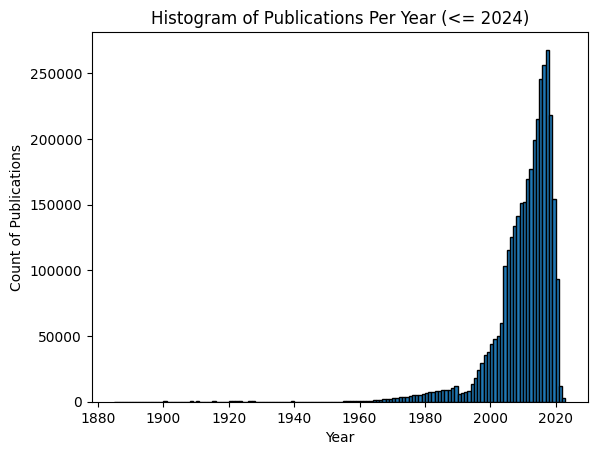

In [10]:
# Plot the raw histogram
plt.hist(df_yearly['year'], bins=range(df_yearly['year'].min(), df_yearly['year'].max() + 1), weights=df_yearly['count'], edgecolor='black')
plt.title(f'Histogram of Publications Per Year (<= {year_cap})')
plt.xlabel('Year')
plt.ylabel('Count of Publications')

# Let's take a look at the filtered json files to see how they are holding here:
## We will call it `Semantic-KG Dataset`

In [23]:
def process_json_df(data:json):
    rows = []

    for doi, details in data.items():
        year = details.get('year')
        abstract = details.get('abstract')
        if (len(abstract) == 0):
            abstract = ""
        paragraphs = details.get('paragraphs')
        total_ln = len(abstract.split('\n'))
        sentence_ct = 0
        for para in paragraphs:
            total_ln += len(para.split('\n'))
            sentence_ct += len(sent_tokenize(para))

        rows.append({'doi': doi, 'year': year, 'abstract': abstract if len(abstract) > 0 else None, 'paragraphs': paragraphs if len(paragraphs) > 0 else None, 'count_paras': len(paragraphs), 'count_total_ln': total_ln, 'count_total_sent': sentence_ct})

    df = pd.DataFrame(rows)
    return df

In [25]:
# path to the directory containing the filtered JSON files:
import nltk
nltk.download('punkt_tab')

PATH_dir_json_files = r"D:\College\Research\Prof_jamshid\Training_SciBert\Dataset\SemanticScholar\downloaded\2023-12-27\s2orc\Share_With_Jamshid\matkg_json_files"

all_data = []

for folder in os.listdir(PATH_dir_json_files):
    
    PATH_curr_json = os.path.join(PATH_dir_json_files, folder)
    if (os.path.isfile(PATH_curr_json)):
        continue
    print('-'*15, '[INFO] FOUND FOLDER : ', folder, ' ', '-'*15)
    if (os.path.isdir(PATH_curr_json)):
        for json_file in os.listdir(PATH_curr_json):

            if (json_file.endswith('.json')):
                print(f"[INFO] Reading {json_file} --->")
                PATH_file = os.path.join(PATH_curr_json, json_file)

                with open(PATH_file) as f:
                    data = json.load(f)
                current_df = process_json_df(data)

                curr_json_data = {'json_filename' : json_file}
                curr_json_data['num_entries'] = current_df.shape[0]
                curr_json_data['count_abstracts'] = current_df['abstract'].count()
                curr_json_data['count_paras'] = current_df['count_paras'].sum()
                curr_json_data['count_abstracts_na'] = current_df['abstract'].isna().sum()
                curr_json_data['count_paras_na'] = current_df['paragraphs'].isna().sum()
                curr_json_data['count_no_body'] = ((current_df['abstract'] == None) & (current_df['paragraphs'] == None)).sum()
                curr_json_data['count_total_ln'] = current_df['count_total_ln'].sum()
                curr_json_data['count_total_sent'] = current_df['count_total_sent'].sum()
                
                curr_json_data["df"] = current_df
                all_data.append(curr_json_data)

json_metadata_df = pd.DataFrame(all_data)

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Stark\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


--------------- [INFO] FOUND FOLDER :  demo_ss_db_b1_b4   ---------------
[INFO] Reading 20231229_122646_00070_i8y36_00e81eb6-6d8a-4f3d-8e2a-478c1b1fe87b.gz_filtered.json --->
[INFO] Reading 20231229_122646_00070_i8y36_0bd0ab3b-114a-441e-9fd6-15efef55a14b.gz_filtered.json --->
[INFO] Reading 20231229_122646_00070_i8y36_0d5242b6-0f2c-4b78-9c9b-7f88d063c701.gz_filtered.json --->
[INFO] Reading 20231229_122646_00070_i8y36_0fb3ab78-e3df-4dd2-86b9-1ad4a81dfa9e.gz_filtered.json --->
[INFO] Reading 20231229_122646_00070_i8y36_20d1904d-c5d8-44d2-bde6-460fbde1b841.gz_filtered.json --->
[INFO] Reading 20231229_122646_00070_i8y36_4a3b617c-2f7d-49cd-af46-68643dc54df5.gz_filtered.json --->
[INFO] Reading 20231229_122646_00070_i8y36_4ffc4028-eee9-4993-8c55-597b5c15ec5d.gz_filtered.json --->
[INFO] Reading 20231229_122646_00070_i8y36_6de21fc7-8e31-4435-98d1-f3c1345db844.gz_filtered.json --->
[INFO] Reading 20231229_122646_00070_i8y36_7af665a0-394e-4583-87f9-1560dc7ea211.gz_filtered.json --->
[INFO] R

In [26]:
current_df.columns.to_list()

['doi',
 'year',
 'abstract',
 'paragraphs',
 'count_paras',
 'count_total_ln',
 'count_total_sent']

In [27]:
json_metadata_df

,json_filename,num_entries,count_abstracts,count_paras,count_abstracts_na,count_paras_na,count_no_body,count_total_ln,count_total_sent,df
0,20231229_122646_00070_i8y36_00e81eb6-6d8a-4f3d...,8694,7515,304042,1179,230,0,312736,1914833,doi year ...
1,20231229_122646_00070_i8y36_0bd0ab3b-114a-441e...,7626,6604,269789,1022,216,0,277415,1674639,doi year \ ...
2,20231229_122646_00070_i8y36_0d5242b6-0f2c-4b78...,8178,7090,286897,1088,216,0,295075,1792109,doi year \ 0 ...
3,20231229_122646_00070_i8y36_0fb3ab78-e3df-4dd2...,8164,7112,288529,1052,237,0,296693,1793141,doi year \ ...
4,20231229_122646_00070_i8y36_20d1904d-c5d8-44d2...,8696,7611,307373,1085,234,0,316069,1940094,doi year \ ...
5,20231229_122646_00070_i8y36_4a3b617c-2f7d-49cd...,8187,7103,283222,1084,247,0,291409,1772733,doi year \ ...
6,20231229_122646_00070_i8y36_4ffc4028-eee9-4993...,7814,6755,273479,1059,194,0,281293,1725422,doi year \ ...
7,20231229_122646_00070_i8y36_6de21fc7-8e31-4435...,7830,6797,273749,1033,192,0,281579,1703285,doi year \ ...
8,20231229_122646_00070_i8y36_7af665a0-394e-4583...,8102,7013,282636,1089,224,0,290738,1766610,doi year \ 0 ...
9,20231229_122646_00070_i8y36_9ab0f0c1-fa7e-4196...,7440,6448,261644,992,182,0,269084,1623644,doi year ...


## Let's plot data by each candidate for what counts as dataset

In [42]:
DF_papers = json_metadata_df['df'].copy().to_list()
print(DF_papers[1].columns.to_list())


['doi', 'year', 'abstract', 'paragraphs', 'count_paras', 'count_total_ln', 'count_total_sent']


In [44]:
df_combined = pd.concat(DF_papers)

In [46]:
final_df = df_combined.groupby('year').agg(
    para_count=('count_paras', 'sum'),                   
    abstract_count=('abstract', lambda x: x.notna().sum()),  
    line_count=('count_total_ln', 'sum'),                
    sentence_count=('count_total_sent', 'sum')           
).reset_index()

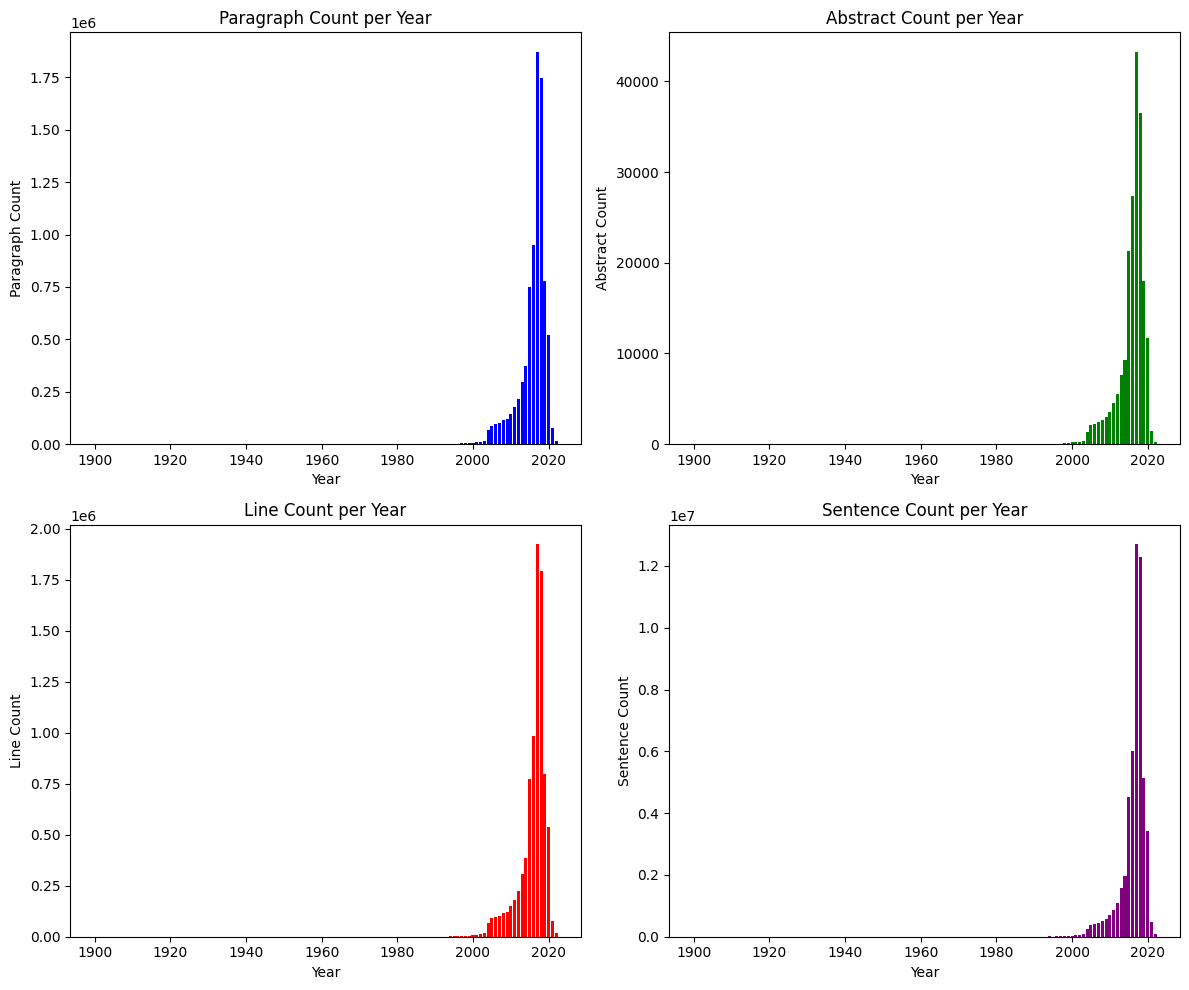

In [47]:
final_dict = final_df.set_index('year').to_dict('index')

years = final_df['year']

fig, axs = plt.subplots(2, 2, figsize=(12, 10))

axs[0, 0].bar(years, final_df['para_count'], color='blue')
axs[0, 0].set_title('Paragraph Count per Year')
axs[0, 0].set_xlabel('Year')
axs[0, 0].set_ylabel('Paragraph Count')

axs[0, 1].bar(years, final_df['abstract_count'], color='green')
axs[0, 1].set_title('Abstract Count per Year')
axs[0, 1].set_xlabel('Year')
axs[0, 1].set_ylabel('Abstract Count')

axs[1, 0].bar(years, final_df['line_count'], color='red')
axs[1, 0].set_title('Line Count per Year')
axs[1, 0].set_xlabel('Year')
axs[1, 0].set_ylabel('Line Count')

axs[1, 1].bar(years, final_df['sentence_count'], color='purple')
axs[1, 1].set_title('Sentence Count per Year')
axs[1, 1].set_xlabel('Year')
axs[1, 1].set_ylabel('Sentence Count')

plt.tight_layout()
plt.show()

In [48]:
total_para_count = final_df['para_count'].sum()
total_abstract_count = final_df['abstract_count'].sum()
total_line_count = final_df['line_count'].sum()
total_sentence_count = final_df['sentence_count'].sum()

final_df['para_count_normalized'] = final_df['para_count'] / total_para_count
final_df['abstract_count_normalized'] = final_df['abstract_count'] / total_abstract_count
final_df['line_count_normalized'] = final_df['line_count'] / total_line_count
final_df['sentence_count_normalized'] = final_df['sentence_count'] / total_sentence_count

## Let's try logarthimic scale

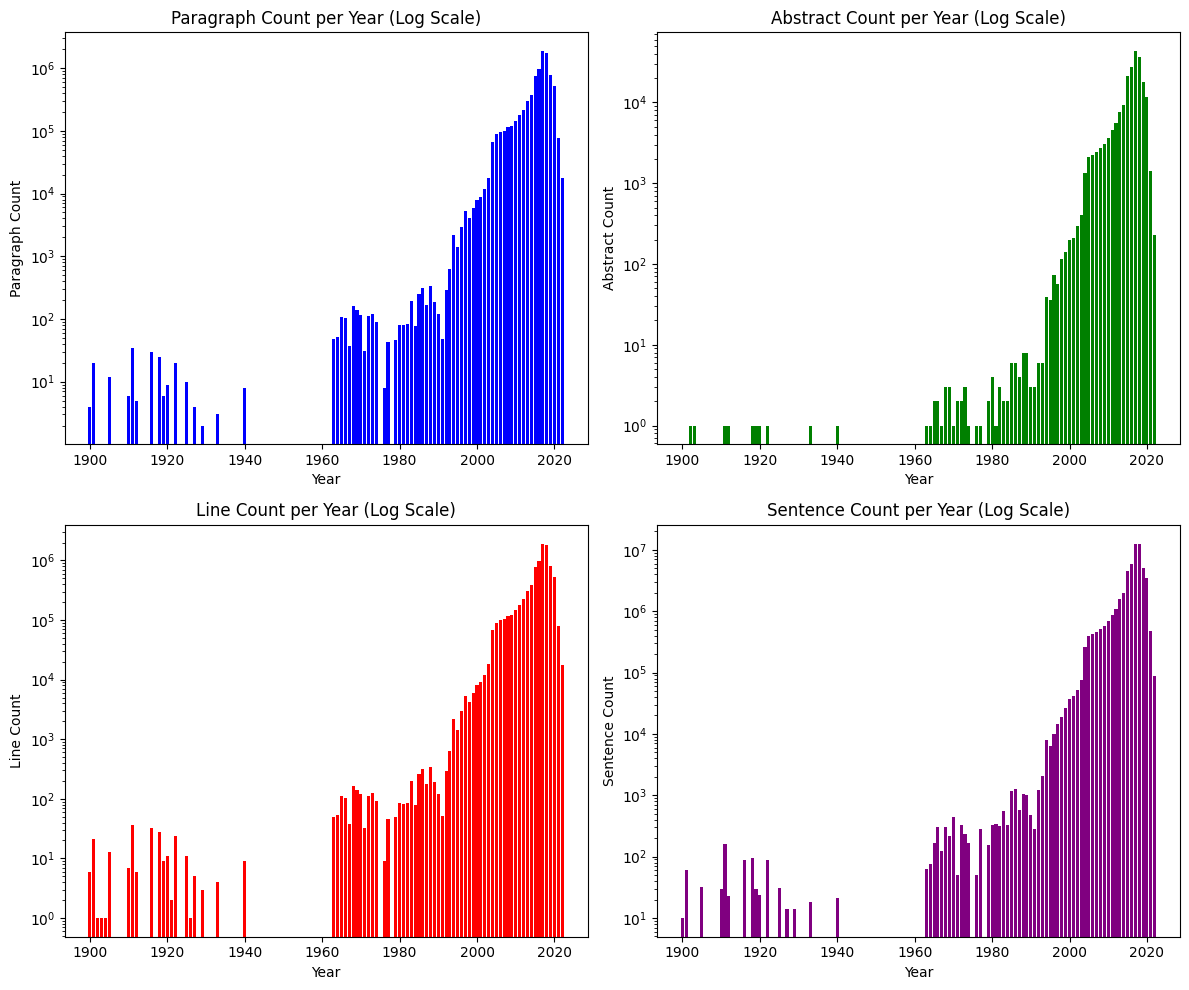

In [50]:
years = final_df['year']

# Create subplots with 4 normalized histograms using log scale
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Paragraph count histogram with log scale
axs[0, 0].bar(years, final_df['para_count'], color='blue')
axs[0, 0].set_title('Paragraph Count per Year (Log Scale)')
axs[0, 0].set_xlabel('Year')
axs[0, 0].set_ylabel('Paragraph Count')
axs[0, 0].set_yscale('log')

# Abstract count histogram with log scale
axs[0, 1].bar(years, final_df['abstract_count'], color='green')
axs[0, 1].set_title('Abstract Count per Year (Log Scale)')
axs[0, 1].set_xlabel('Year')
axs[0, 1].set_ylabel('Abstract Count')
axs[0, 1].set_yscale('log')

# Line count histogram with log scale
axs[1, 0].bar(years, final_df['line_count'], color='red')
axs[1, 0].set_title('Line Count per Year (Log Scale)')
axs[1, 0].set_xlabel('Year')
axs[1, 0].set_ylabel('Line Count')
axs[1, 0].set_yscale('log')

# Sentence count histogram with log scale
axs[1, 1].bar(years, final_df['sentence_count'], color='purple')
axs[1, 1].set_title('Sentence Count per Year (Log Scale)')
axs[1, 1].set_xlabel('Year')
axs[1, 1].set_ylabel('Sentence Count')
axs[1, 1].set_yscale('log')

# Adjust layout
plt.tight_layout()
plt.show()

In [30]:
print('Total number of papers (filtered through MatKG2 from semantic Scholar): ', json_metadata_df['num_entries'].sum())
print("Total number of papers in MatKG2 ArangoDB Database: ", matkg_df.shape[0])
print(f"That mean a total of { matkg_df.shape[0] - json_metadata_df['num_entries'].sum()} papers were not present in SemanticScholar?")

Total number of papers (filtered through MatKG2 from semantic Scholar):  246152
Total number of papers in MatKG2 ArangoDB Database:  3474972
That mean a total of 3228820 papers were not present in SemanticScholar?


## There are a total of **~246k** research papers present in this filtered Dataset
## This number was **~3.47 Million** research papers in the original MatKG2 ArangoDB Dataset
## This mean, a total of **~3.2 Million** research papers are missing from this dataset

In [31]:
print("Total number of Abstracts in Semantic-KG Dataset: ", json_metadata_df['count_abstracts'].sum())
print("Total number of MISSING Abstracts in Semantic-KG Dataset: ", json_metadata_df['num_entries'].sum() - json_metadata_df['count_abstracts'].sum())

Total number of Abstracts in Semantic-KG Dataset:  213369
Total number of MISSING Abstracts in Semantic-KG Dataset:  32783


## There are a total of ~**213k** abstracts from all the papers in this dataset
## Meaning there are ~**32.7k** research papers that have no abstract.

In [32]:
print("Total number of Paragraphs in Semantic-KG Dataset: ", json_metadata_df['count_paras'].sum())
print("Total number of MISSING Paragraphs in Semantic-KG Dataset: ", json_metadata_df['count_paras_na'].sum())

Total number of Paragraphs in Semantic-KG Dataset:  8578124
Total number of MISSING Paragraphs in Semantic-KG Dataset:  6783


## There are a total of ~**8.5Million** Paragraphs from all the papers in this dataset
## Meaning there are **6.7k** research papers that have no Paragraphs.

In [33]:
print("Total number of Lines in Semantic-KG Dataset: ", json_metadata_df['count_total_ln'].sum())

Total number of Lines in Semantic-KG Dataset:  8824276


## There are a total of ~**8.8 Million** lines in this Datasett!!

In [43]:
print("Total number of papers with neither abstract nor paragraphs (meaning having no full body text): ", json_metadata_df['count_no_body'].sum())

Total number of papers with neither abstract nor paragraphs (meaning having no full body text):  0


## Intrestingly there are no papers that have complete text missing. 
* I'm pretty sure th reason is because I skipped paras and abstracts with none entries from SemanticSchollar when filtering this dataset.
* The following is a screen shot from the script `create_json_dataset.py` which is what created this filtered json dataset:

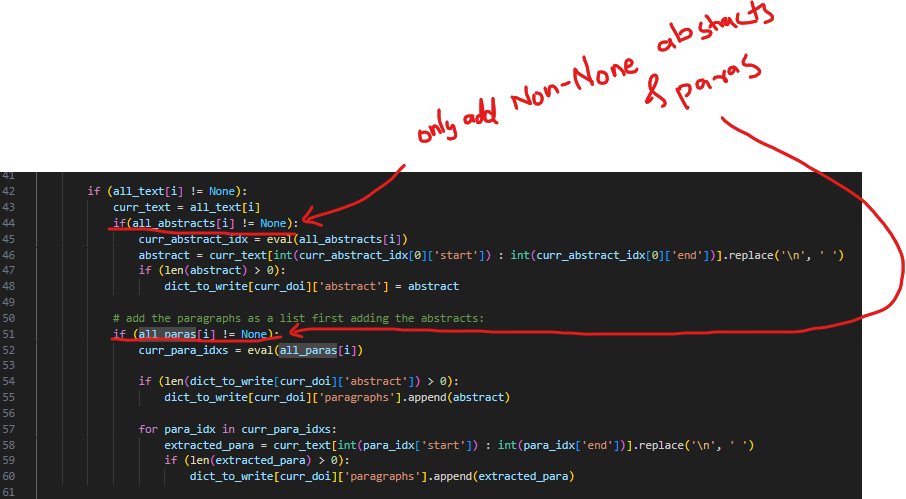


# But according to this code block, there should not be empty abstracts and paras too, then why are we getting those? (TODO)

## Let's verify the metadata from the files on the server

In [19]:
path_created_df = r"D:\College\Research\Prof_jamshid\Hypothesis_Generation_Active_Learning\dataset_scripts\2024_DatasetMetadata.csv"
DF_aiscalar_metadata = pd.read_csv(path_created_df, sep='\t')
DF_aiscalar_metadata.head()
# print(DF_aiscalar_metadata.columns.to_list())

,Unnamed: 0,JsonFile,doi,year_cap,Abs,Para,ParaCnt
0,0,20231229_122646_00070_i8y36_ed2e2f4b-bf9d-4b82...,10.1038/s41598-017-11349-z,True,True,True,93.0
1,1,20231229_122646_00070_i8y36_ed2e2f4b-bf9d-4b82...,10.1016/j.msea.2017.05.057,True,True,True,25.0
2,2,20231229_122646_00070_i8y36_ed2e2f4b-bf9d-4b82...,10.1038/s41467-018-03216-w,True,True,True,37.0
3,3,20231229_122646_00070_i8y36_ed2e2f4b-bf9d-4b82...,10.1038/s41598-017-09564-9,True,True,True,113.0
4,4,20231229_122646_00070_i8y36_ed2e2f4b-bf9d-4b82...,10.1038/srep24109,True,True,True,16.0


In [45]:
with_abs = (DF_aiscalar_metadata['Abs'] == True).sum()
print('Entresi_with_abstract: ', with_abs)

with_paras = (DF_aiscalar_metadata['Para'] == True).sum()
print('Entresi_with_paras: ', with_paras)

print('Para Count (Total): ', DF_aiscalar_metadata['ParaCnt'].sum())

Entresi_with_abstract:  213369
Entresi_with_paras:  239369
Para Count (Total):  8578124.0


## Plotting Training Examples per year:

In [ ]:
# Num

## Let's load this up in a database

In [24]:
import pyodbc
from tqdm import tqdm

def get_mssql_odbc_driver():
    drivers = [driver for driver in pyodbc.drivers() if 'SQL Server' in driver]
    if drivers:
        return drivers[-1]
    else:
        raise Exception("No SQL Server ODBC Driver found. Make sure ODBC drivers are installed.")
    
def connect_to_mssql(server, database, username=None, password=None):
    driver = get_mssql_odbc_driver()
    connection_string = f"""
        DRIVER={{{driver}}};
        SERVER={server};
        DATABASE={database};
        UID={username};
        PWD={password};
        Trusted_Connection=no;
    """

    if username == None or password == None:
        connection_string = f"""
        DRIVER={{{driver}}};
        SERVER={server};
        DATABASE={database};
        Trusted_Connection=yes;
    """
    
    try:
        connection = pyodbc.connect(connection_string)
        print(f"Connected to MSSQL database '{database}' on server '{server}'")
        return connection
    except Exception as e:
        print(f"Error connecting to MSSQL database: {e}")
        return None

In [25]:
## Add your database credentials here:
server = 'DESKTOP-SC072N0\MSSQLSERVER01'
database = 'SemanticKG'
conn = connect_to_mssql(server, database)
cursor = conn.cursor() if conn is not None else exit(-1)

Connected to MSSQL database 'SemanticKG' on server 'DESKTOP-SC072N0\MSSQLSERVER01'


In [26]:
def insert_tblJsonFile(cursor:pyodbc.Connection.cursor, conn:pyodbc.Connection, entries:tuple):
    QUERY_insert_tblJsonFiles = """INSERT INTO tblJsonFiles
           ([JsonFile]
           ,[NumEntries]
           ,[NumAbs]
           ,[NumPara]
           ,[NumAbsLn]
           ,[NumParaLn]
           ,[NumLn])
     VALUES
           (?
           ,?
           ,?
           ,?
           ,?
           ,?
           ,?)"""
    VALUES_insert_tblJsonFiles = entries
    try:
        cursor.execute(QUERY_insert_tblJsonFiles, VALUES_insert_tblJsonFiles)
        conn.commit()
    except Exception as e:
        print("Error while writing to tblJsonFiles: ", e)


def insert_tblPaper(cursor:pyodbc.Connection.cursor, conn:pyodbc.Connection, json_df:pd.DataFrame):

    QUERY_insert_tblPaper = """INSERT INTO tblPaper
           ([doi]
           ,[Year]
           ,[JsonFile]
           ,[Abs]
           ,[Para]
           ,[NumParaLn]
           ,[NumAbsLn])
     VALUES
           (?
           ,?
           ,?
           ,?
           ,?
           ,?
           ,?)"""
    
    data = list(json_df[['doi', 'year', 'JsonFile', 'abstract', 'paragraphs', 'count_para_lines', 'count_abstract_lines']].itertuples(index=False, name=None))

    try:
        cursor.executemany(QUERY_insert_tblPaper, data)
        conn.commit()
    except Exception as e:
        print("Error while writing to tblPaper: ", e)

In [27]:
for json_entry in tqdm(all_data):
    current_df = json_entry['df']

    entries_json_file = (
        json_entry['json_filename'],            # JsonFile
        int(json_entry['num_entries']),              # NumEntries
        int(json_entry['count_abstracts']),          # NumAbs
        int(json_entry['count_paras']),              # NumPara 
        int(current_df['count_abstract_lines'].sum()),   # NumAbsLn
        int(current_df['count_para_lines'].sum()),       # NumParaLn
        int(json_entry['count_lines'])               # NumLn
    )

    print(f"[INFO] Writing {json_entry['json_filename']} ...")
    insert_tblJsonFile(cursor, conn, entries_json_file)

    current_df.insert(2, 'JsonFile', json_entry['json_filename'])
    insert_tblPaper(cursor, conn, current_df)

  0%|          | 0/30 [00:00<?, ?it/s]

[INFO] Writing 20231229_122646_00070_i8y36_00e81eb6-6d8a-4f3d-8e2a-478c1b1fe87b.gz_filtered.json ...
Error while writing to tblJsonFiles:  ('23000', "[23000] [Microsoft][ODBC Driver 17 for SQL Server][SQL Server]Violation of PRIMARY KEY constraint 'PK_tblJsonFiles'. Cannot insert duplicate key in object 'dbo.tblJsonFiles'. The duplicate key value is (20231229_122646_00070_i8y36_00e81eb6-6d8a-4f3d-8e2a-478c1b1fe87b.gz_filtered.json). (2627) (SQLExecDirectW); [23000] [Microsoft][ODBC Driver 17 for SQL Server][SQL Server]The statement has been terminated. (3621)")
Error while writing to tblPaper:  ("A TVP's rows must all be the same size.", 'HY000')
[INFO] Writing 20231229_122646_00070_i8y36_0bd0ab3b-114a-441e-9fd6-15efef55a14b.gz_filtered.json ...
Error while writing to tblJsonFiles:  ('23000', "[23000] [Microsoft][ODBC Driver 17 for SQL Server][SQL Server]Violation of PRIMARY KEY constraint 'PK_tblJsonFiles'. Cannot insert duplicate key in object 'dbo.tblJsonFiles'. The duplicate key va

100%|██████████| 30/30 [00:00<00:00, 49.07it/s]

Error while writing to tblPaper:  ('23000', "[23000] [Microsoft][ODBC Driver 17 for SQL Server][SQL Server]Violation of PRIMARY KEY constraint 'PK_tblPaper'. Cannot insert duplicate key in object 'dbo.tblPaper'. The duplicate key value is (10.1039/c7sc01347g). (2627) (SQLExecDirectW); [23000] [Microsoft][ODBC Driver 17 for SQL Server][SQL Server]The statement has been terminated. (3621)")
[INFO] Writing 20231229_122646_00070_i8y36_4a3b617c-2f7d-49cd-af46-68643dc54df5.gz_filtered.json ...
Error while writing to tblJsonFiles:  ('23000', "[23000] [Microsoft][ODBC Driver 17 for SQL Server][SQL Server]Violation of PRIMARY KEY constraint 'PK_tblJsonFiles'. Cannot insert duplicate key in object 'dbo.tblJsonFiles'. The duplicate key value is (20231229_122646_00070_i8y36_4a3b617c-2f7d-49cd-af46-68643dc54df5.gz_filtered.json). (2627) (SQLExecDirectW); [23000] [Microsoft][ODBC Driver 17 for SQL Server][SQL Server]The statement has been terminated. (3621)")
Error while writing to tblPaper:  ("A TV

In [28]:
conn.close()